<a href="https://colab.research.google.com/github/jurtta66/tracking_synapse/blob/main/Kononov/basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Используем fast.ai

Сетап

In [ ]:
! [ -e /content ] && pip install -Uqq fastbook nbdev
import fastbook
fastbook.setup_book()
from fastbook import *

Сперва преобразуем кадры с видеокамер в картинки людей.
Для этого пробежимся по кадрам, на каждом детектируем людей, для каждой детекции обрежем bbox из кадра в новое изображение.


Путь к папке с кадрами

In [43]:
path = Path('/content/drive/MyDrive/comp_v/data/images/train')
path

Path('/content/drive/MyDrive/comp_v/data/images/train')

In [3]:
from fastai.vision.all import *
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T

import matplotlib.pyplot as plt
import matplotlib.patches as patches

from PIL import Image

Скачаем предобученную модель для детекции

In [45]:
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

Определим функции predict и отрисовки картинки кадра с bbox, 'вырезки' области из изображения

In [5]:
def predict(img):
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    with torch.no_grad():
        pred = model([img])[0]
    return pred['labels'].detach().numpy(), pred['boxes'].detach().numpy(), pred['scores'].detach().numpy()

def show_img_with_bbox(img, bbox):
    fig, ax = plt.subplots()
    ax.imshow(img)
    x1, y1, x2, y2 = bbox
    rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='g', facecolor='none')
    ax.add_patch(rect)
    plt.show()

def show_img(img):
    fig, ax = plt.subplots()
    ax.imshow(img)
    plt.show()

def crop_img(img, bbox):
    x1, y1, x2, y2 = map(int, bbox)
    return img.crop((x1, y1, x2, y2))

Закинем в папку вырезанные изображения людей.

In [46]:
output_path = Path('/content/drive/MyDrive/cv/synapse/person_images')
str(output_path)

In [ ]:
i = 0
for img_path in path.ls():
    person_count = 0
    i += 1
    print(i, end = ', ')
    img = PILImage.create(img_path)
    labels, boxes, scores = predict(img)
    if i == 201:
        print('done 200, input?')
        input()
    for label, bbox, score in zip(labels, boxes, scores):
        if label == 1 and score > 0.5:
            person_count += 1
            #print(f'Person detected in {img_path.name} with probability {score:.04f}')
            #print(f'Bounding box: {bbox}')
            person = crop_img(img, bbox)
            person.save(str(output_path) + '/' + str(i) + '_' + str(person_count) + '.jpg', 'JPEG')
            #show_img_with_bbox(img, bbox)
            #show_img(person)
            #input()

In [7]:
len(output_path.ls())

2355

Теперь пропустим этих людей через resnet с обрезанным последним слоем, и для каждого человека сохраним вектор значений предпоследнего слоя. (если бы сохраняли последний слой реснет - то получили бы аргумент для сигмоиды -> вероятность, что на картинке человек или собака или допустим чайник. Нам это не нужно, мы знаем что на картинке человек.  

In [8]:
transform = T.Compose([
    T.Resize((256 * 3, 256)),
    T.ToTensor(),
    T.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])
transform_to_pil = T.ToPILImage()

Загружаем обрезанные изображения людей

In [ ]:
images = []
for filename in os.listdir(str(output_path)):
    image = Image.open(os.path.join(str(output_path), filename))
    #show_img(image)
    #print(image.size)
    image = transform(image)

    #show_img(transform_to_pil(image))
    #print(transform_to_pil(image).size)
    #input()
    images.append(image)

In [ ]:
images[0].shape, len(images)

Теперь возьмем классификатор, обрежем выходной слой и пустим через него наши изображения, после чего возьмем значения нового выходного слоя.

In [ ]:
resnet = models.resnet18(pretrained=True)

# Удаление последнего слоя
modules = list(resnet.children())[:-1]
resnet = torch.nn.Sequential(*modules)

# Отключение обучения для всех слоев
for p in resnet.parameters():
    p.requires_grad = False

# Пропуск изображений через модель
features = []
for image in images:
    # Изменение размера изображения и добавление размерности пакета
    image = torch.unsqueeze(image, 0)
    # Пропуск изображения через модель
    feature = resnet(image)
    # Удаление размерности пакета и добавление в список признаков
    features.append(torch.squeeze(feature))

Сделаем тоже самое, но для 2355 изображений людей и специальной сетки re-id OSNet



In [ ]:
!pip install torchreid

In [ ]:
import torchreid

# Загрузка OSNet
osnet = torchreid.models.build_model(
    name='osnet_x1_0',
    num_classes=1041, # это значение не имеет значения для извлечения признаков
    loss='softmax',
    pretrained=True
)

# Перевод модели в режим оценки
osnet.eval()

# Пропуск изображений через модель
osnet_features = []
with torch.no_grad():
    for image in images:
        # Изменение размера изображения и добавление размерности пакета
        image = torch.unsqueeze(image, 0)
        # Пропуск изображения через модель
        feature = osnet(image)
        # Удаление размерности пакета и добавление в список признаков
        osnet_features.append(torch.squeeze(feature))

In [ ]:
osnet_features_np = np.array([tensor.tolist() for tensor in osnet_features])

Сохраним osnet_features в текстовый файл

In [11]:
#np.save('/content/drive/MyDrive/cv/synapse/osnet-features-vectors', osnet_features_np)
osnet_features_np = np.load('/content/gdrive/MyDrive/cv/synapse/osnet-features-vectors/osnet-features-vectors.npy')

In [12]:
osnet_features_np.shape

(2355, 512)

Сократим размерности векторов признаков с (1, 512) до (1, 2) и (1, 3) с помощью t-sne.

In [13]:
from sklearn.manifold import TSNE

# экземпляры t-sne
tsne2 = TSNE(n_components=2)
tsne3 = TSNE(n_components=3)

# Преобразование t-sne
osnet_2 = tsne2.fit_transform(osnet_features_np)
osnet_3 = tsne3.fit_transform(osnet_features_np)
#f_reduced_2 = tsne2.fit_transform(features_np)
#f_reduced_3 = tsne3.fit_transform(features_np)

Кластеризуем вектора размерности 2 (3). Я поглядел на первые 100 картинок, там 45- 60 людей. Хотя здесь 2355 людей, и если отношение такое же, нужна примерна половина кластеров, но я сделал 700. Так возможно похожие люди в один кластер попадут (подозреваю, стоит сделать еще меньше по этой же причине). А пока хочется именно одинакового человека на кластере отлавливать.

In [ ]:
from sklearn.cluster import KMeans

n_clusters = 770  #
kmeans = KMeans(n_clusters=n_clusters)

kmeans.fit_transform(osnet_2)
cluster_labels = kmeans.labels_
cluster_labels

Покажем на 2д графике кластеры

<ipython-input-41-b7bbbc99dc4a>:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(point[0], point[1], c=colors[cluster_labels[i]])


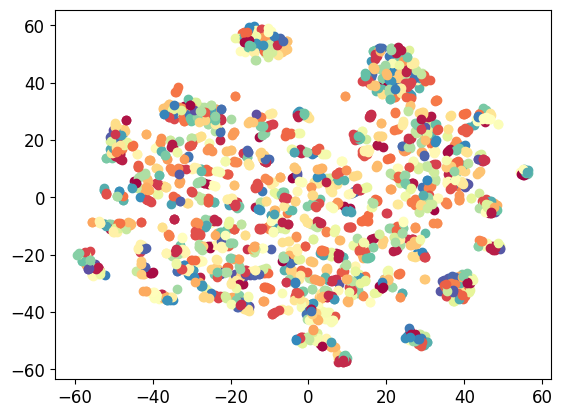

In [41]:
# Спектральная карта цветов
colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))

# График
for i in range(len(osnet_features_np)):
    point = osnet_2[i]
    plt.scatter(point[0], point[1], c=colors[cluster_labels[i]])

plt.show()

Определим метод, выводящий все картинки одного кластера.

5
5


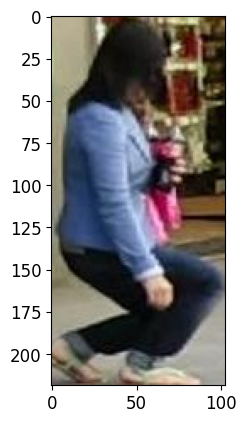

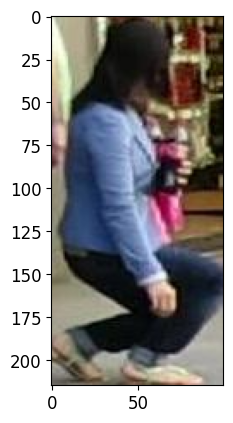

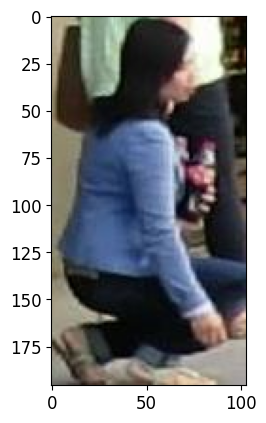

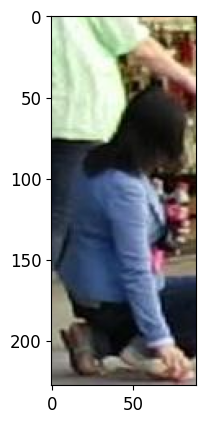

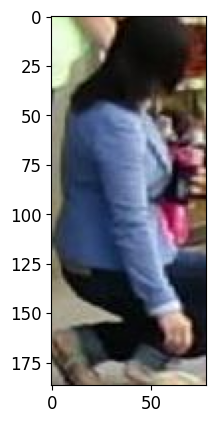

In [42]:
def show_cluster_imgs(cluster_label, img_path, batch_size=10):
    # Цикл по директории, получаем список индексов людей одного кластера.
    cluster_indices = [i for i in range(len(osnet_2)) if cluster_labels[i] == cluster_label]
    # Цикл по папке людей, если индекс есть в cluster_indices -> добавляем в массив
    cluster_imgs = []
    print(len(cluster_indices))
    index = 0
    for img in img_path.ls():
        if index in cluster_indices:
            img = PILImage.create(img)
            #img = transform(img)
            cluster_imgs.append(img)
        index += 1
    print(len(cluster_imgs))

    for i in range(min(batch_size, len(cluster_imgs))):
        show_img(cluster_imgs[i])

show_cluster_imgs(100, output_path)



Успех!
